#### 基本ライブラリの読み込み

In [1]:
import os, sys
import glob

import warnings
warnings.simplefilter('ignore')

import numpy as np
from sklearn.metrics import accuracy_score
from PIL import Image

# 自作モジュールのインポート
from utils.train import evaluate_history, torch_seed
from utils.model import get_model
from utils.dataset import MyDataset

# 必要ライブラリのインポート
import matplotlib.pyplot as plt

# PyTorch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms

from tqdm.notebook import tqdm

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

np.random.seed(1)

#### Cudaのチェック

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### データ読み込み関数

In [3]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                  データ読み込み関数                                     -#
#-------------------------------------------------------------------------------------------#
def load_data_(root_dir='../data/gw_dataset'):
    """
    グループワーク用　学習用データ読み込み関数

    Args:
        * root_dir: 配布したgw_datasetへのパスを指定する (default: '../data/gw_dataset')

    Output:
        * X_train:  正解ラベル付き学習用画像   shape: (140x150,528)
                    1行あたり、画像1枚の画素値を格納したnp.array
                    画像140枚、各画像224x224=150,528次元のベクトル

        * y_train:  X_trainの正解ラベル        shape: (140, )
                    クラス数は7　140枚分のクラスラベル（0～6）の整数が格納されている

        * X_trainu: 正解ラベルなし学習用画像   shape: (210x150,528)
                    形式はX_trainと同じ

        * X_val:   正解ラベル付き検証用画像   shape: (70x150,528)
                    形式はX_trainと同じ

        * y_val:    X_valの正解ラベル          shape: (70, )
                    形式はy_valと同じ
    """

    #----------------- 学習用データの読み込み -------------------#
    train_paths = sorted(glob.glob(os.path.join(root_dir, "train", "*.png")))

    X_train = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in train_paths])
    y_train = np.load(os.path.join(root_dir, "y_train.npy"))

    #------------ ラベルなし学習用データの読み込み --------------#
    trainu_paths = sorted(glob.glob(os.path.join(root_dir, "train-u", "*.png")))
    X_trainu = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in trainu_paths])

    #----------------- 検証用データの読み込み -------------------#
    val_paths = sorted(glob.glob(os.path.join(root_dir,"val", "*.png")))
    X_val = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in val_paths])
    y_val = np.load(os.path.join(root_dir, "y_val.npy"))

    return X_train, y_train, X_trainu, X_val, y_val

In [4]:
### データ読み込み関数の実行
X_train, y_train, X_trainu, X_val, y_val = load_data_() # すべて必要な場合
print(X_train.shape, y_train.shape, X_trainu.shape, X_val.shape, y_val.shape)

# X_train, y_train, _, X_val, y_val = load_data_() # いらないデータがある場合
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(140, 150528) (140,) (210, 150528) (1210, 150528) (1210,)


#### 評価関数

In [5]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                       評価関数                                          -#
#-------------------------------------------------------------------------------------------#

def eval_(y_pred):
    """
    グループワーク用　評価関数
    実行する前にy_valがglobalスコープに読み込まれている必要がある

    Args:
        * y_pred:   識別結果　y_valと同形式・同shapeでなければならない
    """

    try:
        y_val
    except NameError as e:
        print("y_valが読み込まれていません")

    assert y_pred.shape == y_val.shape, 'y_predとy_valのサイズが一致しません'

    print("valデータでの識別精度:{0:.3f}".format(accuracy_score(y_val, y_pred)))

#### データセットの作成

In [6]:
# 分類先クラスのリスト作成
classes = [ '0', '1', '2', '3', '4', '5', '6']

# データを復元
X_train_reshaped = X_train.reshape(-1, 224, 224, 3)
X_val_reshaped = X_val.reshape(-1, 224, 224, 3)
X_trainu_reshaped = X_trainu.reshape(-1, 224, 224, 3)

# データセット作成
train_data = MyDataset(X_train_reshaped, y_train, type='train')
val_data = MyDataset(X_val_reshaped, y_val, type='val')
trainu_data = MyDataset(X_trainu_reshaped, None, type='no_trans')

# データ件数確認
print(f'訓練データ: {len(train_data)}件')
print(f'ラベルなし訓練データ: {len(trainu_data)}件')
print(f'検証データ: {len(val_data)}件')

# データローダー作成
batch_size = 25
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
unlabeled_loader = DataLoader(trainu_data, batch_size=batch_size, shuffle=False)

訓練データ: 140件
ラベルなし訓練データ: 210件
検証データ: 1210件


#### モデルの定義

In [7]:
# 試行回数
num_epochs = 100

# historyファイルを初期化する
history = np.zeros((0, 5), dtype=float)

# 学習モデル定義
model_name = "swin"
num_classes = len(classes)
net = get_model(model_name=model_name, num_classes=num_classes)

# 乱数初期化
torch_seed()

# GPUの利用
net = net.to(device)

# 学習率
lr = 1e-4

# 損失関数定義
Cel = nn.CrossEntropyLoss()
L2l = nn.MSELoss()

# 最適化関数定義
optimizer = optim.Adam(net.parameters(), lr=lr)

# Sharpenの温度
T = 0.5

# ラベルなしのデータ拡張回数
K = 2

# β分布のハイパラ
alpha = 0.1

# 半教師学習の重み
lambda_u = 100

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

#### MixMatch

In [8]:
# unlabeledデータ用 K個のデータ拡張
first_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

second_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
# interleave
def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

def linear_rampup(current, rampup_length=num_epochs):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

In [10]:
# 学習
base_epochs = len(history)

for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    net.train()

    cnt = 0
    for (inputs, labels), inputs_u in zip(train_loader, unlabeled_loader):
        # print(type(inputs), inputs.size())
        # print(type(inputs_u), inputs_u[0].size())

        # ラベルなしデータに対して2種類のデータ拡張を施す
        inputs_u1 = torch.stack([first_transform(inputs_u[i]) for i in range(inputs_u.size(0))]).to(device)
        inputs_u2 = torch.stack([second_transform(inputs_u[i]) for i in range(inputs_u.size(0))]).to(device)

        # one-hotラベルへ変換
        labels = torch.nn.functional.one_hot(labels, num_classes=7)

        # GPUに送る
        inputs, labels, inputs_u = inputs.to(device), labels.to(device), inputs_u.to(device)

        with torch.no_grad():
            outputs_u1 = net(inputs_u1)
            outputs_u2 = net(inputs_u2)
            p = (torch.softmax(outputs_u1, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
            pt = p**(1/T)
            labels_u = pt / pt.sum(dim=1, keepdim=True)
            labels_u = labels_u.detach()

        # print(labels_u)

        batch_size = inputs.size(0)

        # Mix-Up
        all_inputs = torch.cat([inputs, inputs_u], dim=0)
        all_labels = torch.cat([labels, labels_u], dim=0)

        l = np.random.beta(alpha, alpha)

        l = max(l, 1-l)

        idx = torch.randperm(all_inputs.size(0))

        input_a, input_b = all_inputs, all_inputs[idx]
        label_a, label_b = all_labels, all_labels[idx]

        mixed_input = l * input_a + (1 - l) * input_b
        mixed_label = l * label_a + (1 - l) * label_b

        # 混ぜたデータをinterleaveする
        mixed_input = list(torch.split(mixed_input, batch_size))
        mixed_input = interleave(mixed_input, batch_size)

        # 学習
        logits = [net(mixed_input[0])]
        for input in mixed_input[1:]:
            logits.append(net(input))

        # interleaveしたデータを戻す
        logits = interleave(logits, batch_size)
        logits_x = logits[0]
        logits_u = torch.cat(logits[1:], dim=0)

        # 損失の計算
        Lx = Cel(logits_x, mixed_label[:batch_size])
        Lu = L2l(logits_u, mixed_label[batch_size:])

        # wをエポック単位で更新
        w = lambda_u * linear_rampup(epoch)

        # 損失の合計
        loss = Lx + w * Lu

        train_loss += loss.item()

        # 逆伝搬と最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    net.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = Cel(outputs, labels)
            val_loss += loss.item()
            _, preds = outputs.max(1)
            val_acc += (preds == labels).sum().item()

    # 平均損失と制度の計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)

    # エポック結果表示
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs+base_epochs}: "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    # 履歴更新
    history = np.vstack((history, [epoch + 1, avg_train_loss, 0.5, avg_val_loss, avg_val_acc]))

    if avg_val_acc == 1.0:
        break

    if avg_val_acc > 0.9738:
        path = 'god.pth'
        torch.save(net.state_dict(), path)


Epoch 1/100: Train Loss: 0.0756 Val Loss: 0.0479, Val Acc: 0.8463
Epoch 11/100: Train Loss: 0.0203 Val Loss: 0.0049, Val Acc: 0.9752
Epoch 21/100: Train Loss: 0.0219 Val Loss: 0.0046, Val Acc: 0.9818
Epoch 31/100: Train Loss: 0.0159 Val Loss: 0.0055, Val Acc: 0.9744
Epoch 41/100: Train Loss: 0.0247 Val Loss: 0.0047, Val Acc: 0.9711
Epoch 51/100: Train Loss: 0.0189 Val Loss: 0.0050, Val Acc: 0.9603
Epoch 61/100: Train Loss: 0.0362 Val Loss: 0.0081, Val Acc: 0.9488
Epoch 71/100: Train Loss: 0.0286 Val Loss: 0.0061, Val Acc: 0.9579
Epoch 81/100: Train Loss: 0.0348 Val Loss: 0.0070, Val Acc: 0.9545
Epoch 91/100: Train Loss: 0.0408 Val Loss: 0.0071, Val Acc: 0.9612


[初期状態] loss: 0.04789, accuracy: 0.84628
[最終状態] loss: 0.00891, accuracy: 0.93719


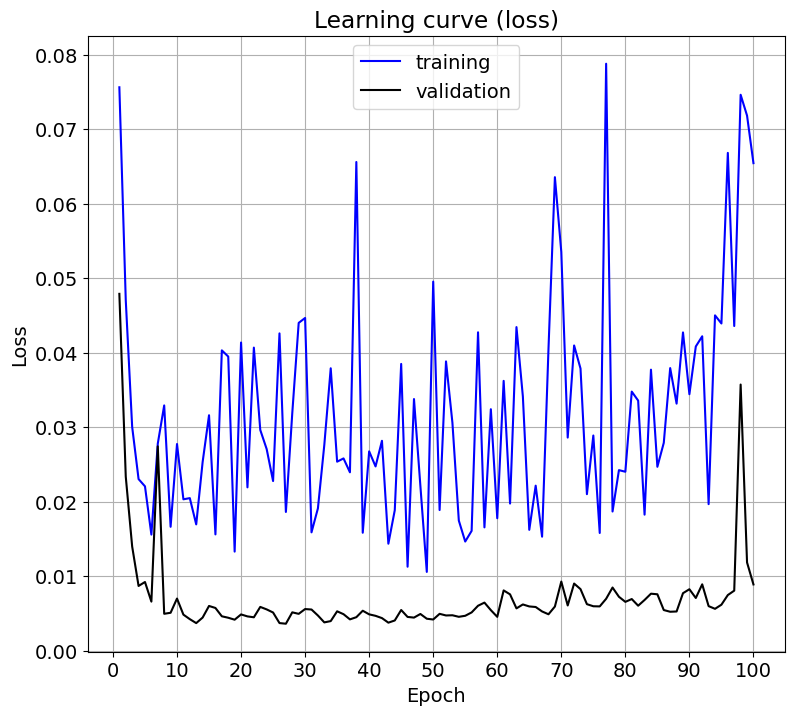

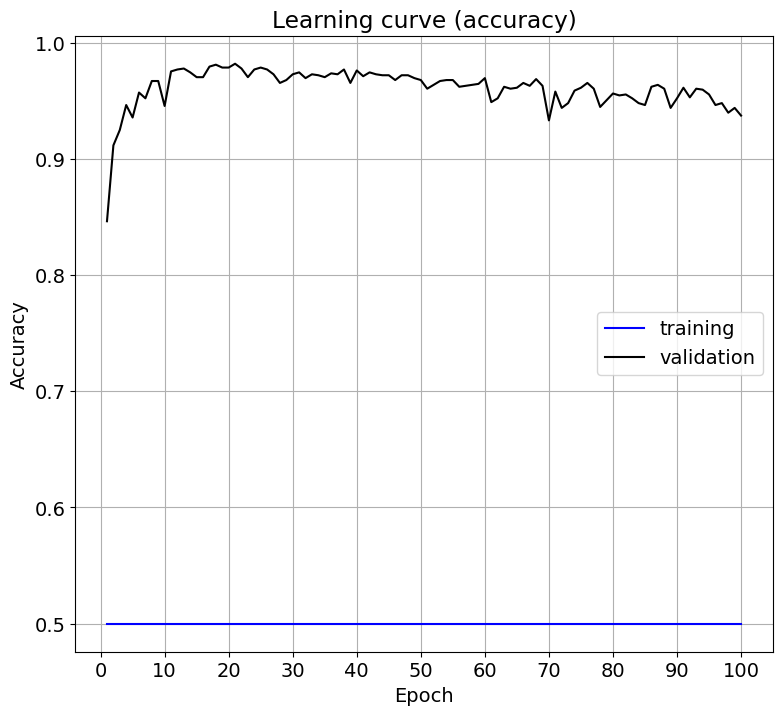

In [11]:
# 結果確認
evaluate_history(history)

In [12]:
path = 'model.pth'
torch.save(net.state_dict(), path)